In [1]:
"""
Things to do with discrete power law
"""

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# intialize parameters and x data
alpha = 1.3  # anomalous exponent
xmin = 1  # minimum value drawn from discrete power law
xmax = 1000  # maximum value of x
x = np.linspace(xmin, xmax, (xmax - xmin) + 1)  # discrete values of x
dx = x[1] - x[0]  # space between points, i.e. timestep

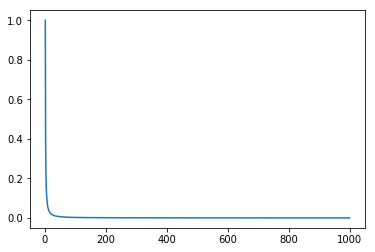

In [4]:
# plot power law with above parameters
unnormalized = x**-alpha
plt.plot(x, unnormalized)
plt.show()

In [5]:
def zeta(x, alpha, upper_limit=10000):
    """ Numberical estimate of Hurwitz zeta function. Used as discrete power law 
    distribution normalization constant
    
    sum from n=0 to infinity of (n + x)^-\alpha
    
    :param x: point at which to evaluate function
    :param alpha: exponent of power law
    :param upper_limit: number of terms used to calculate Hurwitz zeta function (highest value of n above)
    
    :type x: float
    :type alpha: float
    :type upper_limit: int

    :return: evaluation of Hurwitz zeta function at x
    :rtype: float
    """
    
    return sum([(n + x)**(-alpha) for n in range(upper_limit)])

In [6]:
# normalize discrete distribution
upper_limit = 100000 # largest value in following sum since we can't sum to infinity
normalized = unnormalized / zeta(xmin, alpha, upper_limit=upper_limit)

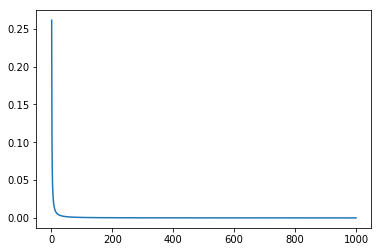

In [7]:
# plot normalized probability distribution
plt.plot(x, normalized)
plt.show()

In [8]:
# show that normalized probability converges to an area of 1
print(sum([i*dx for i in normalized]))  # increase xmax to get this closer to 1

0.917897169593


In [9]:
def discrete_powerlaw_CCDF(val, xmin, alpha, upper_limit=10000):
    """ Calculate the complementary cumulative distribution function of a discrete power 
    law distribution such that P(x) = Pr(X >= x)
    
    :param x: value at which to evaluate CDF
    :param xmin: lower bound of power law PDF
    :param alpha: exponent of power law
    :param upper_limit: number of terms used to calculate Hurwitz zeta function
    
    :type x: float
    :type xmin: float
    :type alpha: float
    :type upper_limit: int
    
    :return CDF of power law PDF evaluated at x
    :rtype float
    """
    return zeta(val, alpha, upper_limit=upper_limit) / zeta(xmin, alpha, upper_limit=upper_limit)

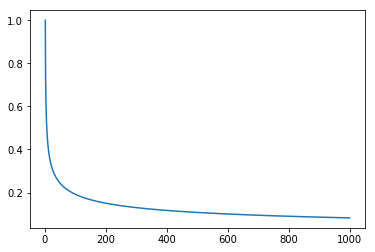

In [10]:
# Plot Complementary Cumulative Distribution Function from xmin to xmax
cdf = [discrete_powerlaw_CCDF(i, xmin, alpha, upper_limit=upper_limit) for i in x]
plt.plot(x, cdf)
plt.show()

In [11]:
def sample_discrete_powerlaw(alpha, xmin, size=1, upper_limit=10000):
    """ Exact method for generating random draws from a discrete power law distribution of
    form t**-alpha
    
    See Appendix D of https://epubs.siam.org/doi/abs/10.1137/070710111.
    
    This method is slow and the approximation might be more useful

    :param alpha: power law exponent
    :param xmin: lower limit of distribution.
    :param size: number of random draws to perform

    :type: alpha: float
    :type xmin: float
    :type size: int

    :return: array of random power law draws
    """

    r = np.random.uniform(0, 1, size=size)
    
    t = np.zeros([size])
    for i, val in enumerate(r):
        x2 = xmin
        while discrete_powerlaw_CCDF(x2, xmin, alpha, upper_limit=upper_limit) > (1 - val):
            x1 = x2
            x2 = 2 * x1
        t[i] = x2
        
    return t

In [14]:
def approximate_discrete_powerlaw_samples(alpha, xmin, size=1):
    """ Approximate random draws from a discrete power law distribution of form t**-alpha.
    Much faster than sample_discrete_powerlaw()
    
    See Appendix D of https://epubs.siam.org/doi/abs/10.1137/070710111

    :param alpha: power law exponent
    :param xmin: lower limit of distribution.
    :param size: number of random draws to perform

    :type: alpha: float
    :type xmin: float
    :type size: int

    :return: array of random power law draws
    """

    r = np.random.uniform(0, 1, size=size)
        
    t = np.round((xmin - 0.5)*(1 - r)**(-1/(alpha -1)) + 0.5)
        
    return t

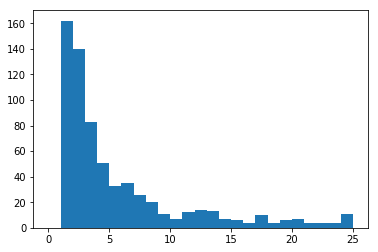

In [15]:
# Generate random values from a discrete power law distributio
ndraws = 1000
#draws = sample_discrete_powerlaw(alpha, xmin, size=ndraws, upper_limit=upper_limit)
draws = approximate_discrete_powerlaw_samples(alpha, xmin, size=ndraws)
plt.hist(draws, range=(0, 25), bins=25)
plt.show()

In [16]:
def discrete_log_likelihood(alpha, x, xmin,  minimize=False, upper_limit=10000):
    """ Calculate log likelihood for alpha given a set of x values that might come from a 
    power law distribution
    
    :param alpha: power law exponent. Calculates the log-likelihood of this value of alpha 
    for the data
    :param x: array of values making up emperical distribution
    :param xmin: lower bound of power law distribution
    :param upper_limit: number of terms used to calculate zeta function
    
    :type alpha: float
    :type x: np.ndarray
    :type xmin: float
    :type upper_limit: int
    
    :return log-likelihood of input parameters
    :rtype float
    """
    
    n = x.size
    z = zeta(xmin, alpha, upper_limit=upper_limit)  # optimization could be fast if this is done outside the function. 
    
    res = -n*np.log(z) - alpha*sum([np.log(i) for i in x])
    
    if minimize:
        return res * - 1
    else:
        return res

Likelihood maximized for alpha = 1.22


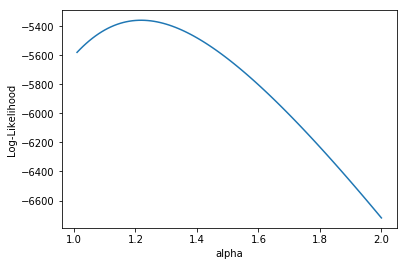

In [17]:
# Calculate log-likelihood of data given a range of alphas
ll = []  # list of log-likelihoods for each alpha tested
alphas = np.linspace(1.01, 2, 100)
for i in alphas:
    ll.append(discrete_log_likelihood(i, draws, xmin, upper_limit=upper_limit))

# Plot the log-likelihood as a function of alpha. The maximum appears near the value
# of alpha we provided. It's not perfect, but we only used 1000 data points and the
# approximated discrete value generator
plt.plot(alphas, ll)
plt.ylabel('Log-Likelihood')
plt.xlabel('alpha')
print('Likelihood maximized for alpha = %.2f' % alphas[np.argmax(ll)])
plt.show()

In [18]:
# Now actually maximize the likelihood
from scipy.optimize import minimize

args = (draws, xmin, True, upper_limit)  # a higher upper limit gives more accurate results
maximum = minimize(discrete_log_likelihood, 1, args=args)
print('Optimized value of alpha: %.3f' % maximum.x)

Optimized value of alpha: 1.218
